In [1]:
import os
import re
from pathlib import Path

import pandas as pd
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
figdir = '../results/figures/mixture_deconvolution_v6'
Path(figdir).mkdir(parents=True, exist_ok=True)
sc.settings.figdir = figdir

In [3]:
adata = sc.read_h5ad('../data/combined/inhouse_peng_lin_all_datatypes.h5ad')
adata

AnnData object with n_obs × n_vars = 103528 × 29092
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'CELL', 'CONDITION', 'Patient', 'Type', 'Cell_type', 'integrated_snn_res.1.2', 'seurat_clusters', 'integrated_snn_res.1', 'integrated_snn_res.1.5', 'integrated_snn_res.2', 'integrated_snn_res.1.25', 'cell_type', 'sample_id', 'dataset', 'ABCA2_p.V804M_depth', 'ABCA2_p.V804M_vaf', 'ABCA2_p.V804M_status', 'ABCA6_p.R1261T_depth', 'ABCA6_p.R1261T_vaf', 'ABCA6_p.R1261T_status', 'ABCA8_p.X1183_splice_depth', 'ABCA8_p.X1183_splice_vaf', 'ABCA8_p.X1183_splice_status', 'ABCB11_p.R696P_depth', 'ABCB11_p.R696P_vaf', 'ABCB11_p.R696P_status', 'ABCB4_p.Q423Efs*13_depth', 'ABCB4_p.Q423Efs*13_vaf', 'ABCB4_p.Q423Efs*13_status', 'ABCC10_p.E314A_depth', 'ABCC10_p.E314A_vaf', 'ABCC10_p.E314A_status', 'ABCC8_p.S579Y_depth', 'ABCC8_p.S579Y_vaf', 'ABCC8_p.S579Y_status', 'ABCE1_p.K513Q_depth', 'ABCE1_p.K513Q_vaf', 'ABCE1_p.K513Q_status', 'ABCF1_p.K76Sfs*60_depth', 'ABCF1_p.K76S

In [101]:
# SQUAM_GENES = adata.uns['top_squam']
# ED_GENES = adata.uns['top_ed']
THRESH = 20
SQUAM_GENES = adata.uns[f'top_{THRESH}_squam']
ED_GENES = adata.uns[f'top_{THRESH}_ed']
ED_GENES = ['B2M']
ED_GENES = ['B2M', 'HLAC', 'HLAA', 'HLAB']
# ED_GENES = ['TMSB10',
#  'MYL6',
#  'S100A11',
#  'PPDPF',
#  'COX6A1',
#  'B2M',
#  'MYL12B',
#  'CLIC1',
#  'SERF2',
#  'HLA-C',
#  'COX4I1',
#  'CFL1',
#  'TMSB4X',
#  'COX6B1',
#  'COX7A2',
#  'SPINT2',
#  'ACTB',
#  'CHCHD2',
#  'CD63',
#  'HLA-A',]

def score_sample(gene_to_expression, subtype):
    if subtype == 'squam':
        return np.mean([gene_to_expression[g] for g in SQUAM_GENES if g in gene_to_expression
                       if not pd.isnull(gene_to_expression[g])])
    elif subtype == 'ed': 
#         print(len(set(gene_to_expression.keys()).intersection(set(ED_GENES))))
#         print([gene_to_expression[g] for g in ED_GENES if g in gene_to_expression])
        return np.mean([gene_to_expression[g] for g in ED_GENES if g in gene_to_expression
                       if not pd.isnull(gene_to_expression[g])])

In [79]:
from sklearn.preprocessing import StandardScaler
def normalize_expression_matrix(df):
    return pd.DataFrame(data=StandardScaler().fit_transform(df.values.transpose()).transpose(),
                       columns=df.columns, index=df.index)

## TCGA

In [23]:
expression_df = pd.read_csv('../data/bulk_rna_seq/tcga.txt', sep='\t', index_col='Gene')
expression_df = normalize_expression_matrix(expression_df)
expression_df

,TCGA-OE-A75W-01A-12R-A32O-07,TCGA-2J-AABT-01A-11R-A41B-07,TCGA-IB-7886-01A-11R-2156-07,TCGA-IB-AAUU-01A-11R-A37L-07,TCGA-2J-AAB6-01A-11R-A41B-07,TCGA-LB-A8F3-01A-11R-A36G-07,TCGA-HZ-A4BH-01A-11R-A26U-07,TCGA-HV-A5A3-11A-11R-A26U-07,TCGA-IB-7646-01A-11R-2156-07,TCGA-2J-AAB9-01A-11R-A41B-07,...,TCGA-L1-A7W4-01A-12R-A36G-07,TCGA-IB-A5SO-01A-11R-A32O-07,TCGA-IB-AAUW-01A-12R-A38C-07,TCGA-2J-AABF-01A-31R-A41B-07,TCGA-H8-A6C1-01A-11R-A32O-07,TCGA-IB-AAUN-01A-12R-A38C-07,TCGA-FB-AAPU-01A-31R-A41B-07,TCGA-HZ-8001-01A-11R-2204-07,TCGA-IB-7651-01A-11R-2156-07,TCGA-3A-A9IJ-01A-11R-A39D-07
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,0.007555,-0.426652,-0.484546,-0.412178,-0.339811,-0.397705,-0.180601,-0.209549,-0.499020,-0.339811,...,0.398341,0.022028,-0.064813,-0.064813,0.195711,-0.383231,-0.542440,-0.252969,-0.180601,2.381219
A1BG-AS1,-0.055960,-0.306757,-0.533086,-0.465799,-0.251704,-0.710479,-0.031492,0.005210,-0.710479,-0.025375,...,0.115315,-0.104896,0.060262,0.243772,-0.135481,-0.478033,-0.814468,-0.062077,-0.000907,0.598558
A1CF,-0.512022,-0.377239,0.421498,0.117407,-0.590369,0.132014,-0.031319,-0.448946,-0.689298,-0.456914,...,-0.711872,-0.593689,0.584167,0.708990,-0.474177,-0.546548,0.457352,-0.340058,-0.566466,1.716210
A2M,-0.707090,1.034191,0.091151,-0.542783,-0.936153,0.111736,0.529060,1.525232,-0.018533,0.668363,...,-0.878039,0.823099,0.684650,0.404798,-0.358624,-0.443549,-1.178256,1.212514,2.838958,-1.081806
A2M-AS1,-0.733575,2.176914,-0.464323,-0.592538,-0.605360,-1.182329,-0.643824,0.343434,-0.207892,-0.169427,...,-0.990006,0.240862,0.497293,0.138289,-0.400215,0.112646,-1.169508,-0.092498,-0.284821,1.625588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,-0.186519,-0.384111,-0.502667,-0.186519,-0.305074,-0.502667,-0.502667,-0.305074,-0.265556,-0.344593,...,6.413073,-0.305074,-0.344593,-0.107482,-0.226037,-0.226037,-0.423630,-0.107482,-0.305074,1.433740
ZYG11B,-1.772540,1.737948,0.436045,-0.054028,-0.006601,-1.757661,0.062213,-0.100524,-0.029850,-0.362765,...,0.223091,-0.388803,0.894501,0.340263,-0.252103,-0.649183,-0.376714,-0.852838,0.965176,1.718420
ZYX,0.834982,2.762488,-0.191350,1.560479,2.292624,-0.037610,0.459223,1.639391,-1.062992,0.754835,...,-1.233351,-0.403112,-0.569958,0.336819,-0.974014,-0.479365,-0.345091,0.941147,-0.796533,-1.923238


In [80]:
highres_classical = pd.read_csv('../data/cibersortx/results/tcga_malignant_classical_v3.txt', sep='\t',
                                index_col='GeneSymbol')
highres_classical = normalize_expression_matrix(highres_classical)

highres_classical

/diskmnt/Projects/Users/estorrs/miniconda3/envs/sc_pdac/lib/python3.7/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/diskmnt/Projects/Users/estorrs/miniconda3/envs/sc_pdac/lib/python3.7/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


,TCGA-OE-A75W-01A-12R-A32O-07,TCGA-2J-AABT-01A-11R-A41B-07,TCGA-IB-7886-01A-11R-2156-07,TCGA-IB-AAUU-01A-11R-A37L-07,TCGA-2J-AAB6-01A-11R-A41B-07,TCGA-LB-A8F3-01A-11R-A36G-07,TCGA-HZ-A4BH-01A-11R-A26U-07,TCGA-HV-A5A3-11A-11R-A26U-07,TCGA-IB-7646-01A-11R-2156-07,TCGA-2J-AAB9-01A-11R-A41B-07,...,TCGA-L1-A7W4-01A-12R-A36G-07,TCGA-IB-A5SO-01A-11R-A32O-07,TCGA-IB-AAUW-01A-12R-A38C-07,TCGA-2J-AABF-01A-31R-A41B-07,TCGA-H8-A6C1-01A-11R-A32O-07,TCGA-IB-AAUN-01A-12R-A38C-07,TCGA-FB-AAPU-01A-31R-A41B-07,TCGA-HZ-8001-01A-11R-2204-07,TCGA-IB-7651-01A-11R-2156-07,TCGA-3A-A9IJ-01A-11R-A39D-07
GeneSymbol,,,,,,,,,,,,,,,,,,,,,
ACTB,0.629840,1.760138,0.345197,1.018809,1.899463,-0.727836,0.490806,1.235180,0.821636,0.353325,...,-0.349099,-0.140907,-1.258254,0.480981,-0.562888,0.442335,-0.029755,0.266418,-0.721224,-1.792155
ACTG1,-0.598884,-1.187251,0.025312,0.349422,0.426383,0.990365,0.269459,2.119007,0.216239,1.133851,...,0.346372,1.153150,-0.922378,-0.503365,-0.345544,-1.130456,2.727921,0.646207,-0.180033,-0.064545
AKR1B1,-0.127932,-0.032246,-0.174955,-0.651501,0.649817,-0.857913,-0.535470,0.779034,0.048113,-0.122768,...,-0.559613,0.138636,-0.505724,0.051602,-0.362564,-0.287567,-0.390866,0.690829,3.348012,3.225314
ANXA2,1.237929,-1.404352,0.440936,1.105888,1.826201,-0.748449,0.082323,-0.419252,1.192055,-0.145870,...,-0.572902,1.008887,-0.850246,0.035942,-0.612288,0.477593,1.731722,-0.093109,-0.007956,-1.595522
ARL4C,0.641273,-1.098214,1.147902,-0.177334,0.785580,-0.124820,0.348289,0.622137,1.743850,0.141721,...,-0.306059,1.011956,-0.757195,-0.639356,-1.052558,0.055571,-1.466967,-0.193032,-0.628576,-1.702921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UQCR10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
VIM,0.446585,-0.253308,-0.574549,-0.708732,-0.824154,1.095371,-0.051433,1.623596,0.298722,0.744805,...,-0.522028,0.773743,-0.051242,-0.381969,-0.819377,-0.722222,-1.653054,1.702287,-0.073078,0.939185
WIPF1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [81]:
~np.isnan(highres_classical.values.transpose()).any(axis=0)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [82]:
highres_squam = pd.read_csv('../data/cibersortx/results/tcga_malignant_squam_v3.txt', sep='\t',
                                index_col='GeneSymbol')
highres_squam = normalize_expression_matrix(highres_squam)

highres_squam

/diskmnt/Projects/Users/estorrs/miniconda3/envs/sc_pdac/lib/python3.7/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/diskmnt/Projects/Users/estorrs/miniconda3/envs/sc_pdac/lib/python3.7/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


,TCGA-OE-A75W-01A-12R-A32O-07,TCGA-2J-AABT-01A-11R-A41B-07,TCGA-IB-7886-01A-11R-2156-07,TCGA-IB-AAUU-01A-11R-A37L-07,TCGA-2J-AAB6-01A-11R-A41B-07,TCGA-LB-A8F3-01A-11R-A36G-07,TCGA-HZ-A4BH-01A-11R-A26U-07,TCGA-HV-A5A3-11A-11R-A26U-07,TCGA-IB-7646-01A-11R-2156-07,TCGA-2J-AAB9-01A-11R-A41B-07,...,TCGA-L1-A7W4-01A-12R-A36G-07,TCGA-IB-A5SO-01A-11R-A32O-07,TCGA-IB-AAUW-01A-12R-A38C-07,TCGA-2J-AABF-01A-31R-A41B-07,TCGA-H8-A6C1-01A-11R-A32O-07,TCGA-IB-AAUN-01A-12R-A38C-07,TCGA-FB-AAPU-01A-31R-A41B-07,TCGA-HZ-8001-01A-11R-2204-07,TCGA-IB-7651-01A-11R-2156-07,TCGA-3A-A9IJ-01A-11R-A39D-07
GeneSymbol,,,,,,,,,,,,,,,,,,,,,
ACTB,1.070947,1.943352,0.246990,0.942451,1.952145,-0.826315,0.529530,1.471352,0.692243,0.170728,...,-0.395049,-0.174999,-1.518951,0.950886,-0.648019,0.568072,-0.075640,0.142953,-0.658870,-1.716867
ACTG1,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
AKR1B1,0.012877,0.270740,-0.062003,-0.813735,1.522286,-1.104819,-0.614965,1.630283,0.343165,0.120189,...,-0.616118,0.805762,-0.632000,0.430077,-0.345383,-0.336792,-0.417019,1.721719,2.122282,2.332743
ANXA2,1.352534,-1.383034,0.429730,0.932383,2.117924,-0.678149,-0.022467,-0.335795,0.865728,-0.186348,...,-0.566415,0.831791,-0.773387,0.041012,-0.582896,0.509294,1.938177,-0.124384,-0.072281,-1.668850
ARL4C,0.336905,-0.933285,0.617948,-0.210374,0.287020,-0.127883,0.143542,0.268708,2.795433,-0.020458,...,-0.313336,0.525530,-0.723653,-0.608458,-0.766909,-0.124688,-1.235418,-0.213994,-0.494300,-1.405062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UQCR10,2.909251,-0.077622,-0.992574,-0.058049,-0.058194,0.879299,-1.539216,-0.477147,0.191357,-0.503384,...,0.472940,-0.515892,-0.389012,-0.679656,0.300831,0.032262,0.025571,1.360433,0.128776,2.547903
VIM,0.031726,-0.328750,-0.557088,-0.723934,-0.833378,0.663165,0.197765,2.385104,0.129278,0.543068,...,-0.497263,0.546798,0.065231,-0.405899,-0.758401,-0.720555,-1.544413,1.048433,0.055932,0.581134
WIPF1,-0.579051,0.400309,0.147213,0.711969,-0.316406,-1.387249,0.883043,0.374380,0.624622,-0.154246,...,-1.145515,0.895440,0.226781,0.871371,-0.348509,-0.743398,-1.208794,0.068493,1.014083,-1.521277


In [83]:
# highres_squam.loc[SQUAM_GENES]

In [84]:
squam_scores, ed_scores = [], []
for sample in highres_classical.columns:
#     gene_to_expression = {g:e for g, e in zip(expression_df.index, expression_df[sample])}
    hc_to_expression = {g:e for g, e in zip(highres_classical.index, highres_classical[sample])}
    sq_to_expression = {g:e for g, e in zip(highres_squam.index, highres_squam[sample])}
    squam_scores.append(score_sample(sq_to_expression, 'squam'))
    ed_scores.append(score_sample(hc_to_expression, 'ed'))
score_df = pd.DataFrame.from_dict({
    'squam': squam_scores,
    'ed': ed_scores
})
score_df.index = highres_classical.columns
score_df

,squam,ed
TCGA-OE-A75W-01A-12R-A32O-07,0.808322,1.353400
TCGA-2J-AABT-01A-11R-A41B-07,-0.525125,-1.118149
TCGA-IB-7886-01A-11R-2156-07,-0.532152,0.696549
TCGA-IB-AAUU-01A-11R-A37L-07,-0.232031,0.791697
TCGA-2J-AAB6-01A-11R-A41B-07,0.755755,0.042011
...,...,...
TCGA-IB-AAUN-01A-12R-A38C-07,0.090804,1.802036
TCGA-FB-AAPU-01A-31R-A41B-07,-0.616501,-0.654450
TCGA-HZ-8001-01A-11R-2204-07,0.244111,0.325359
TCGA-IB-7651-01A-11R-2156-07,-0.297862,2.096734


In [106]:
for g in ED_GENES: print(g, g in highres_classical.index)

B2M True
HLAC True
HLAA True
HLAB True


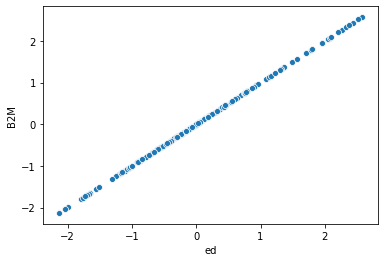

In [86]:
sns.scatterplot(x=score_df['ed'], y=highres_classical.loc[ED_GENES[0]])

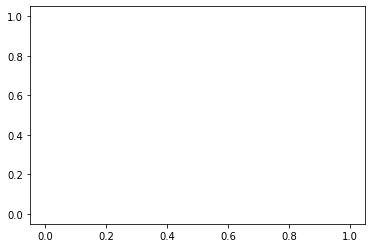

In [87]:
sns.scatterplot(x=score_df['squam'], y=expression_df.loc[SQUAM_GENES[1]])

In [88]:
# score_df = pd.DataFrame(data=score_df.values / np.max(score_df.values, axis=0),
#                        columns=score_df.columns, index=score_df.index)
score_df = pd.DataFrame(data=score_df.values,
                       columns=score_df.columns, index=score_df.index)
score_df['dataset'] = 'TCGA'
score_df

,squam,ed,dataset
TCGA-OE-A75W-01A-12R-A32O-07,0.808322,1.353400,TCGA
TCGA-2J-AABT-01A-11R-A41B-07,-0.525125,-1.118149,TCGA
TCGA-IB-7886-01A-11R-2156-07,-0.532152,0.696549,TCGA
TCGA-IB-AAUU-01A-11R-A37L-07,-0.232031,0.791697,TCGA
TCGA-2J-AAB6-01A-11R-A41B-07,0.755755,0.042011,TCGA
...,...,...,...
TCGA-IB-AAUN-01A-12R-A38C-07,0.090804,1.802036,TCGA
TCGA-FB-AAPU-01A-31R-A41B-07,-0.616501,-0.654450,TCGA
TCGA-HZ-8001-01A-11R-2204-07,0.244111,0.325359,TCGA
TCGA-IB-7651-01A-11R-2156-07,-0.297862,2.096734,TCGA


In [89]:
## make TCGA dataframe
tcga_clinical = pd.read_csv('../data/bulk_rna_seq/tcga/clinical.cases_selection.2020-05-01/clinical.tsv', sep='\t')
tcga_clinical = tcga_clinical.drop_duplicates('submitter_id')
tcga_clinical = tcga_clinical.set_index('submitter_id')

tcga_clinical.index.name = 'submitter_id'

print(score_df.shape)
## drop normals
to_drop = [x for x in score_df.index if '-11A-' in x]
score_df = score_df.drop(to_drop, axis=0)

## limit to first part of id
score_df.index = [x[:12] for x in score_df.index]
print(score_df.shape)

print('tcga clinical', tcga_clinical.shape)
print(len(set(tcga_clinical.index).intersection(set(score_df.index))))

tcga_combined = pd.merge(score_df, tcga_clinical, left_index=True, right_index=True)
tcga_combined = tcga_combined.loc[~tcga_combined.index.duplicated(keep='first')]
tcga_combined.index.name = 'sample_id'

def safe_int(x):
    if pd.isna(x): return 0.
    if x == '--': return 0
    return int(x)

# # make a column for survival time
tcga_combined['survival_time'] = [safe_int(dtd) if vs == 'Dead' else safe_int(dtf) 
        for dtd, dtf, vs in zip(tcga_combined['days_to_death'],
                           tcga_combined['days_to_last_follow_up'],
                           tcga_combined['vital_status'])]
tcga_combined['survival_time'] = [int((x / 365) * 12) if not pd.isnull(x) else x
                                    for x in tcga_combined['survival_time']]
## get rid of zero survival times
print(tcga_combined.shape)
tcga_combined = tcga_combined[tcga_combined['survival_time'] > 0]
print(tcga_combined.shape)

tcga_combined['status'] = [1 if vs == 'Alive' else 2 for vs in tcga_combined['vital_status']]
tcga_combined['morphology_numerical'] = [x[:-2] for x in tcga_combined['morphology']] 


tcga_combined = tcga_combined[tcga_combined['primary_diagnosis'] != 'Neuroendocrine carcinoma, NOS']

tcga_combined.columns = [x.replace(' ', '_') for x in tcga_combined.columns]


# tcga_combined.to_csv('../results/survival/eus13_reclustered/tcga.tsv', sep='\t', header=True, index=True)


tcga_combined

(182, 3)
(178, 3)
tcga clinical (150, 180)
142
(142, 184)
(136, 184)


,squam,ed,dataset,case_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,...,tumor_regression_grade,tumor_stage,updated_datetime.3,vascular_invasion_present,vascular_invasion_type,weiss_assessment_score,wilms_tumor_histologic_subtype,year_of_diagnosis,survival_time,morphology_numerical
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-2J-AAB6,0.755755,0.042011,TCGA,70797499-16e6-48cc-8ae4-1e692713dad3,TCGA-PAAD,75,--,--,--,--,...,--,stage iia,--,--,--,--,--,2012,9,8500
TCGA-2J-AAB8,-0.198677,1.320044,TCGA,2e8f90f4-aed3-43b0-985c-dfdc2581f24f,TCGA-PAAD,71,--,--,--,--,...,--,stage iib,--,--,--,--,--,2012,2,8500
TCGA-2J-AAB9,-0.021089,-0.753301,TCGA,a5748656-5330-417a-8938-01f69ddb3576,TCGA-PAAD,70,--,--,--,--,...,--,stage iib,--,--,--,--,--,2012,20,8500
TCGA-2J-AABA,-0.649831,-0.467635,TCGA,e3a19e63-bae5-498b-9687-41194aa5728d,TCGA-PAAD,55,--,--,--,--,...,--,stage iib,--,--,--,--,--,2012,19,8500
TCGA-2J-AABE,-0.341747,-0.782015,TCGA,58c1c391-5ea3-4432-bb1e-e7e1974954bc,TCGA-PAAD,73,--,--,--,--,...,--,stage iia,--,--,--,--,--,2012,22,8500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-XN-A8T3,0.471022,-0.770297,TCGA,dd7bcdd8-1660-4dab-9860-9d136c4cee77,TCGA-PAAD,67,--,--,--,--,...,--,stage ib,--,--,--,--,--,2012,31,8500
TCGA-XN-A8T5,-0.100705,0.198475,TCGA,382b279f-87e1-4dbc-a2ca-c1dfde1cf254,TCGA-PAAD,53,--,--,--,--,...,--,stage ib,--,--,--,--,--,2012,23,8500
TCGA-YB-A89D,-0.151450,-0.131779,TCGA,b84b58c7-95b8-4162-8e61-414f8fe422c6,TCGA-PAAD,59,--,--,--,--,...,--,stage iib,--,--,--,--,--,2013,11,8500


In [90]:
import umap
from sklearn.preprocessing import StandardScaler
X = highres_classical.values.transpose()
bad_genes_mask = ~np.isnan(X).any(axis=0)
X = X[:, bad_genes_mask]
bad_samples_mask = ~np.isnan(X).any(axis=1)
X = X[bad_samples_mask]
X = umap.UMAP().fit_transform(StandardScaler().fit_transform(X))
df = pd.DataFrame({
    'sample_id': highres_classical.loc[:, bad_samples_mask].columns,
    'UMAP1': X[:, 0].flatten(),
    'UMAP2': X[:, 1].flatten()
})
df.index = [x[:12] for x in df['sample_id']]
df = pd.merge(df, tcga_combined, left_index=True, right_index=True)
df

,sample_id,UMAP1,UMAP2,squam,ed,dataset,case_id,project_id,age_at_index,age_is_obfuscated,...,tumor_regression_grade,tumor_stage,updated_datetime.3,vascular_invasion_present,vascular_invasion_type,weiss_assessment_score,wilms_tumor_histologic_subtype,year_of_diagnosis,survival_time,morphology_numerical
TCGA-2J-AAB6,TCGA-2J-AAB6-01A-11R-A41B-07,6.576186,14.570682,0.755755,0.042011,TCGA,70797499-16e6-48cc-8ae4-1e692713dad3,TCGA-PAAD,75,--,...,--,stage iia,--,--,--,--,--,2012,9,8500
TCGA-2J-AAB8,TCGA-2J-AAB8-01A-12R-A41B-07,8.162406,14.508291,-0.198677,1.320044,TCGA,2e8f90f4-aed3-43b0-985c-dfdc2581f24f,TCGA-PAAD,71,--,...,--,stage iib,--,--,--,--,--,2012,2,8500
TCGA-2J-AAB9,TCGA-2J-AAB9-01A-11R-A41B-07,8.921319,13.856987,-0.021089,-0.753301,TCGA,a5748656-5330-417a-8938-01f69ddb3576,TCGA-PAAD,70,--,...,--,stage iib,--,--,--,--,--,2012,20,8500
TCGA-2J-AABA,TCGA-2J-AABA-01A-21R-A41B-07,9.069779,14.086640,-0.649831,-0.467635,TCGA,e3a19e63-bae5-498b-9687-41194aa5728d,TCGA-PAAD,55,--,...,--,stage iib,--,--,--,--,--,2012,19,8500
TCGA-2J-AABE,TCGA-2J-AABE-01A-12R-A41B-07,8.865761,15.435758,-0.341747,-0.782015,TCGA,58c1c391-5ea3-4432-bb1e-e7e1974954bc,TCGA-PAAD,73,--,...,--,stage iia,--,--,--,--,--,2012,22,8500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-XN-A8T5,TCGA-XN-A8T5-01A-12R-A36G-07,7.108954,11.971976,-0.100705,0.198475,TCGA,382b279f-87e1-4dbc-a2ca-c1dfde1cf254,TCGA-PAAD,53,--,...,--,stage ib,--,--,--,--,--,2012,23,8500
TCGA-YB-A89D,TCGA-YB-A89D-11A-11R-A36G-07,7.799932,13.074984,-0.151450,-0.131779,TCGA,b84b58c7-95b8-4162-8e61-414f8fe422c6,TCGA-PAAD,59,--,...,--,stage iib,--,--,--,--,--,2013,11,8500
TCGA-YB-A89D,TCGA-YB-A89D-01A-12R-A36G-07,7.959161,14.182792,-0.151450,-0.131779,TCGA,b84b58c7-95b8-4162-8e61-414f8fe422c6,TCGA-PAAD,59,--,...,--,stage iib,--,--,--,--,--,2013,11,8500
TCGA-YY-A8LH,TCGA-YY-A8LH-01A-11R-A36G-07,6.082817,15.340081,-0.141075,1.082285,TCGA,ede2e8a7-465e-4725-880d-519899aba0c0,TCGA-PAAD,61,--,...,--,stage iib,--,--,--,--,--,2009,66,8500


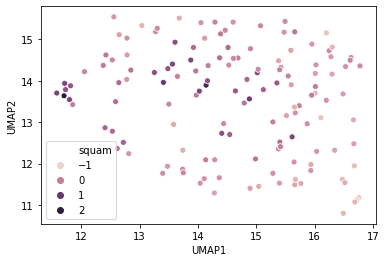

In [35]:
import seaborn as sns
sns.scatterplot(x='UMAP1', y='UMAP2', data=df, hue='squam')

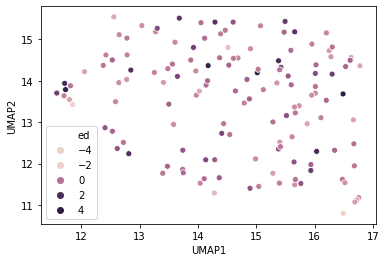

In [36]:
import seaborn as sns
sns.scatterplot(x='UMAP1', y='UMAP2', data=df, hue='ed')

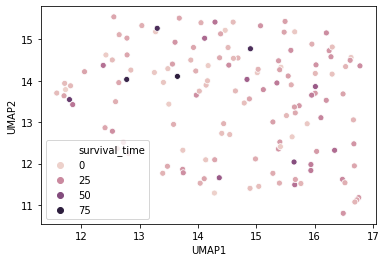

In [37]:
import seaborn as sns
sns.scatterplot(x='UMAP1', y='UMAP2', data=df, hue='survival_time')

## bailey

In [38]:
expression_df = pd.read_csv('../data/bulk_rna_seq/bailey.txt', sep='\t', index_col='Gene')
expression_df = normalize_expression_matrix(expression_df)
expression_df

,SA518851,SA528771,SA528766,SA528763,SA518817,SA518765,SA518854,SA518806,SA528767,SA518750,...,SA412299,SA411841,SA411797,SA411769,SA411833,SA411430,SA411406,SA411923,SA411305,SA411682
Gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,-0.101343,-1.220180,-1.064149,-0.869313,-0.180332,-0.635254,-0.221130,0.621710,-0.653835,-0.906041,...,2.055759,0.330806,-0.441008,-0.452085,-0.950768,-0.587375,-0.229860,0.710920,-0.163579,2.564118
TNMD,-0.349600,-0.349600,-0.349600,-0.349600,-0.349600,3.288432,-0.349600,-0.349600,-0.349600,0.750238,...,-0.178195,-0.349600,0.290679,-0.349600,-0.197329,-0.349600,-0.349600,-0.349600,-0.160363,-0.349600
DPM1,0.594734,-1.122884,-1.385691,-1.212093,-0.445036,0.190337,-0.230756,-0.424543,-1.203050,-0.791419,...,-0.442278,1.058491,1.076413,-0.834835,-0.573199,1.203835,-0.705541,0.193656,0.591054,0.951215
SCYL3,-1.361914,0.506540,-0.321508,-0.651374,0.159313,-0.069632,0.303640,0.907858,1.357664,0.198648,...,1.384668,-1.285902,0.656422,-0.558427,1.169987,-0.520955,0.255237,-0.897169,-0.396294,-0.994878
C1orf112,0.139014,-0.034174,-0.254442,-0.346574,-0.281137,-0.188254,0.030338,-0.200321,0.633722,-0.261208,...,-0.247256,0.619587,-0.000422,-0.480045,-0.213347,-0.291333,-0.439445,-0.052172,0.285900,2.072487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC008735.3,-0.149997,-0.149997,-0.149997,-0.149997,-0.149997,-0.149997,-0.149997,-0.149997,-0.149997,-0.149997,...,0.067980,-0.149997,-0.149997,-0.149997,-0.149997,-0.149997,-0.149997,-0.149997,-0.149997,-0.149997
AC245884.10,-0.553140,0.850015,-0.668322,0.438481,0.068061,0.124074,-0.411772,0.786234,2.081895,4.290460,...,-0.668322,-0.668322,-0.454486,-0.668322,-0.363193,-0.367664,-0.347302,-0.016417,-0.668322,-0.495374
AC008753.3,-0.192174,-0.192174,-0.192174,-0.192174,-0.192174,1.563554,-0.192174,7.865052,-0.192174,-0.192174,...,-0.192174,-0.192174,2.176834,-0.192174,-0.192174,-0.192174,-0.192174,-0.192174,-0.192174,-0.192174


In [107]:
highres_classical = pd.read_csv('../data/cibersortx/results/bailey_classical_v5.txt', sep='\t',
                                index_col='GeneSymbol')
highres_classical = normalize_expression_matrix(highres_classical)

highres_classical

/diskmnt/Projects/Users/estorrs/miniconda3/envs/sc_pdac/lib/python3.7/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/diskmnt/Projects/Users/estorrs/miniconda3/envs/sc_pdac/lib/python3.7/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


,SA518851,SA528771,SA528766,SA528763,SA518817,SA518765,SA518854,SA518806,SA528767,SA518750,...,SA412299,SA411841,SA411797,SA411769,SA411833,SA411430,SA411406,SA411923,SA411305,SA411682
GeneSymbol,,,,,,,,,,,,,,,,,,,,,
STRAP,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
VIM,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
TMSB10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
SLC2A3,1.934880,0.188756,-0.686415,0.250493,-0.841671,0.523162,0.207130,-0.100755,-0.603946,-0.809662,...,-0.601583,-0.881861,-0.371960,-0.328382,-0.471564,0.075877,-0.774775,-0.170919,2.483442,-0.819894
BCAT1,1.037472,-0.664986,-0.697655,-0.304065,-0.611771,-0.524746,0.192772,2.740164,-0.565397,-0.670552,...,2.374165,1.985982,-0.656959,-0.649196,3.600422,-0.581780,-0.558923,1.907927,-0.048170,2.636695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HLAB,0.124698,-0.396213,-0.778416,-0.586770,2.574755,1.793553,-0.535051,-0.312453,-0.953270,-1.232581,...,1.712296,-1.238363,0.943531,-0.111854,1.196003,0.284734,1.936229,-0.443146,-1.188438,-0.990236
MIF,-1.939048,0.770186,1.184356,1.128177,-0.159480,-0.809439,0.742137,0.848962,1.422705,1.574625,...,-1.215663,-0.962223,-0.223080,-1.121068,1.460337,-0.403143,-0.856113,0.670436,-0.661186,-0.921710
BRK1,0.021596,-1.720077,-1.775107,-1.465124,0.876299,-0.666618,0.185061,-0.455132,-1.817190,-0.688200,...,-0.982401,1.763292,1.655797,0.249522,0.058374,0.534893,-0.616112,0.154998,-0.107917,1.727972


In [114]:
highres_classical.loc['HLAC']

SA518851   -0.441077
SA528771   -0.892128
SA528766   -1.041340
SA528763   -0.761994
SA518817    2.675213
              ...   
SA411430    0.476723
SA411406    2.245430
SA411923   -0.608273
SA411305   -1.138881
SA411682   -1.116478
Name: HLAC, Length: 92, dtype: float64

In [108]:
highres_squam = pd.read_csv('../data/cibersortx/results/bailey_squam_v5.txt', sep='\t',
                                index_col='GeneSymbol')
highres_squam = normalize_expression_matrix(highres_squam)

highres_squam

/diskmnt/Projects/Users/estorrs/miniconda3/envs/sc_pdac/lib/python3.7/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/diskmnt/Projects/Users/estorrs/miniconda3/envs/sc_pdac/lib/python3.7/site-packages/sklearn/utils/extmath.py:711: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


,SA518851,SA528771,SA528766,SA528763,SA518817,SA518765,SA518854,SA518806,SA528767,SA518750,...,SA412299,SA411841,SA411797,SA411769,SA411833,SA411430,SA411406,SA411923,SA411305,SA411682
GeneSymbol,,,,,,,,,,,,,,,,,,,,,
STRAP,2.565855,0.579711,-0.163413,-0.165073,-0.719280,0.232699,-0.672885,-0.288067,0.398846,-1.604653,...,-0.324764,1.825398,0.388875,-1.166975,-0.850153,-0.213343,-0.632898,-0.262427,0.533681,1.696799
VIM,2.190229,-0.880957,-1.337760,0.898391,-0.835246,-0.191486,-0.096728,-0.164157,-0.904281,-0.208851,...,0.659711,-1.541659,-1.311269,-0.166727,-0.696101,-0.299894,0.197740,-0.439211,0.027365,-1.308210
TMSB10,-0.130954,-0.897512,-0.873618,-0.805326,-0.686839,-0.350302,-0.348167,-0.310559,-0.929378,-1.000355,...,-0.479725,2.998318,1.060618,-0.392960,-0.765670,-0.229229,-0.437309,0.062455,1.577929,2.593595
SLC2A3,1.611572,0.781299,-0.848686,0.586586,-1.051009,1.116542,0.355015,-0.042136,-0.755099,-1.041152,...,-0.711195,-1.236652,-0.408382,-0.050448,-0.390469,0.650271,-1.014728,0.002574,1.999667,-1.074589
BCAT1,1.763754,-0.781772,-0.842485,-0.213364,-0.691563,-0.559532,0.789198,1.951650,-0.656586,-0.922617,...,1.987551,2.056550,-0.720527,-0.684912,2.625274,-0.620285,-0.639210,2.018845,0.349650,2.314187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HLAB,0.387850,-0.364144,-0.883464,-0.565013,1.542052,1.281902,-0.583552,-0.154568,-0.840109,-1.324015,...,1.313415,-1.400574,1.220122,0.018212,0.820745,0.445337,1.969318,-0.369163,-1.383880,-1.162455
MIF,0.194115,-0.614854,-0.817485,-0.661693,-0.424277,-0.188393,-0.586541,-0.635998,-0.838542,-0.843663,...,0.115260,-0.039686,-0.389839,0.030931,-0.673470,2.046076,0.016146,-0.504154,2.094719,2.221389
BRK1,-0.201190,-1.381257,-1.310023,-1.246037,0.549092,-0.698801,-0.114451,-0.669534,-1.512545,-0.685140,...,-0.935080,2.139674,1.540377,0.309265,-0.084569,0.424072,-0.701600,-0.071653,-0.286850,1.993918


In [109]:
squam_scores, ed_scores = [], []
for sample in highres_classical.columns:
#     gene_to_expression = {g:e for g, e in zip(expression_df.index, expression_df[sample])}
    hc_to_expression = {g:e for g, e in zip(highres_classical.index, highres_classical[sample])}
    sq_to_expression = {g:e for g, e in zip(highres_squam.index, highres_squam[sample])}
    squam_scores.append(score_sample(sq_to_expression, 'squam'))
    ed_scores.append(score_sample(hc_to_expression, 'ed'))
score_df = pd.DataFrame.from_dict({
    'squam': squam_scores,
    'ed': ed_scores
})
score_df.index = highres_classical.columns
score_df

,squam,ed
SA518851,0.947864,-0.158793
SA528771,-0.652850,-0.747680
SA528766,-0.817678,-0.971109
SA528763,-0.458382,-0.743776
SA518817,-0.548825,1.304636
...,...,...
SA411430,0.212116,0.110169
SA411406,-0.276263,1.761717
SA411923,0.076914,-0.289074
SA411305,0.199484,-1.052195


In [110]:
SQUAM_GENES[2]

'GAPDH'

In [111]:
# sns.scatterplot(x=score_df['ed'], y=highres_classical.loc[ED_GENES[4]])

In [113]:
sns.scatterplot(x=score_df['ed'], y=expression_df.loc[ED_GENES[1]])

KeyError: 'HLAC'

In [115]:
# score_df = pd.DataFrame(data=score_df.values / np.max(score_df.values, axis=0),
#                        columns=score_df.columns, index=score_df.index)
score_df = pd.DataFrame(data=score_df.values,
                       columns=score_df.columns, index=score_df.index)
score_df['dataset'] = 'bailey'
score_df

,squam,ed,dataset
SA518851,0.947864,-0.158793,bailey
SA528771,-0.652850,-0.747680,bailey
SA528766,-0.817678,-0.971109,bailey
SA528763,-0.458382,-0.743776,bailey
SA518817,-0.548825,1.304636,bailey
...,...,...,...
SA411430,0.212116,0.110169,bailey
SA411406,-0.276263,1.761717,bailey
SA411923,0.076914,-0.289074,bailey
SA411305,0.199484,-1.052195,bailey


In [116]:
bailey_metadata = pd.read_csv('../data/bulk_rna_seq/bailey/metadata.tsv', sep='\t')
bailey_metadata = bailey_metadata.set_index('icgc_sample_id')

bailey_combined = pd.merge(score_df, bailey_metadata, left_index=True, right_index=True)

## exclude nans
mask = [not pd.isnull(x) for x in bailey_combined['donor_vital_status']]
bailey_combined = bailey_combined[mask]

bailey_combined['survival_time'] = [int((x / 365) * 12) if not pd.isnull(x) else x
                                    for x in bailey_combined['donor_survival_time']]
bailey_combined = bailey_combined[bailey_combined['survival_time'] > 0]
bailey_combined['status'] = [1 if vs == 'alive' else 2 for vs in bailey_combined['donor_vital_status']]

bailey_combined.index.name = 'sample_id'

bailey_combined.columns = [x.replace(' ', '_') for x in bailey_combined.columns]

bailey_combined

,squam,ed,dataset,project_code_x,submitted_sample_id,icgc_specimen_id,submitted_specimen_id,icgc_donor_id,submitted_donor_id_x,analyzed_sample_interval,...,donor_tumour_staging_system_at_diagnosis,donor_tumour_stage_at_diagnosis,donor_tumour_stage_at_diagnosis_supplemental,donor_survival_time,donor_interval_of_last_followup,prior_malignancy,cancer_type_prior_malignancy,cancer_history_first_degree_relative,survival_time,status
sample_id,,,,,,,,,,,,,,,,,,,,,
SA518851,0.947864,-0.158793,bailey,PACA-AU,8070200,SP108125,8070200,DO49204,ICGC_0543,NaN,...,TNM,NaN,NaN,156.0,156.0,unknown,NaN,unknown,5,2
SA528766,-0.817678,-0.971109,bailey,PACA-AU,8069050,SP110832,8069050,DO49198,ICGC_0512,NaN,...,TNM,NaN,NaN,251.0,251.0,unknown,NaN,unknown,8,2
SA528763,-0.458382,-0.743776,bailey,PACA-AU,8068990,SP110833,8068990,DO49199,ICGC_0513,NaN,...,TNM,NaN,NaN,1095.0,1095.0,unknown,NaN,unknown,36,2
SA518854,-0.143763,-0.454127,bailey,PACA-AU,8070203,SP108071,8070203,DO49185,ICGC_0542,NaN,...,TNM,NaN,NaN,179.0,179.0,unknown,NaN,unknown,5,1
SA518806,-0.080723,-0.722004,bailey,PACA-AU,8069444,SP108066,8069444,DO49183,ICGC_0521,NaN,...,TNM,NaN,NaN,429.0,429.0,unknown,NaN,unknown,14,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SA411430,0.212116,0.110169,bailey,PACA-AU,8044438,SP71982,8044438,DO33552,ICGC_0149,NaN,...,TNM,NaN,NaN,873.0,873.0,unknown,NaN,unknown,28,1
SA411406,-0.276263,1.761717,bailey,PACA-AU,8044426,SP71958,8044426,DO33544,ICGC_0153,NaN,...,TNM,NaN,NaN,412.0,412.0,unknown,NaN,unknown,13,2
SA411923,0.076914,-0.289074,bailey,PACA-AU,8058509,SP77059,8058509,DO34849,ICGC_0326,NaN,...,TNM,NaN,NaN,272.0,272.0,unknown,NaN,unknown,8,2


## moffit

In [117]:
expression_df = pd.read_csv('../data/bulk_rna_seq/moffit.txt', sep='\t', index_col='Gene')
expression_df = normalize_expression_matrix(expression_df)
expression_df

,GSM1844105,GSM1844106,GSM1844107,GSM1844108,GSM1844109,GSM1844110,GSM1844111,GSM1844112,GSM1844113,GSM1844114,...,GSM1844240,GSM1844241,GSM1844242,GSM1844243,GSM1844244,GSM1844245,GSM1844246,GSM1844247,GSM1844248,GSM1844249
Gene,,,,,,,,,,,,,,,,,,,,,
A1BG,-0.239305,1.788598,-0.618543,-0.339224,0.233040,0.505547,1.763618,-0.273368,1.947560,0.010493,...,-0.193887,0.242124,1.284461,1.768160,0.405628,1.943018,1.132312,2.687870,1.681866,2.285922
A1CF,-1.126832,-0.350762,-0.379833,1.388445,2.321247,2.336414,-0.114401,0.670517,-0.412696,-1.506020,...,-1.487060,-1.571746,-0.135889,-1.311370,0.038538,-0.364665,-0.766604,3.520743,-1.203934,0.144710
A2BP1,1.178759,-0.542427,-0.369309,-0.172888,-0.758823,-0.971891,-0.898649,-0.309384,0.616128,-1.747589,...,1.561615,-0.529110,1.445093,1.564944,-0.961903,0.183334,0.599482,1.398485,2.147550,0.209968
A2LD1,-1.883344,0.035863,0.056411,-1.139497,1.331772,1.301635,-1.679231,-0.487433,0.441348,-1.094291,...,-0.564146,-0.947714,-0.670997,0.379703,-0.383322,0.045452,-1.098401,-0.829904,-1.542243,2.257813
A2M,-0.238582,-0.743184,-0.194335,0.703781,-0.730004,-0.399565,0.974910,-3.829165,-0.046532,1.312881,...,0.975852,0.747086,0.164346,-0.628331,1.310057,1.942692,1.609429,0.584220,-0.834502,-1.222368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,1.752044,-0.401302,3.289158,-0.851358,1.357379,0.201081,0.609593,-1.509133,-0.671336,-0.851358,...,2.513677,3.725367,-0.733651,2.084393,-0.152040,1.391999,-0.595172,-0.671336,0.796540,-0.962141
ZYG11B,-0.014282,-0.754098,0.437034,-0.302782,0.411326,0.302782,-0.736959,-2.365125,0.034277,1.805264,...,-0.294212,0.042846,-1.308245,-0.579855,-0.085693,1.216840,0.902632,0.482737,-1.859536,0.122827
ZYX,-0.225830,-0.064651,-1.070798,1.742506,-0.820076,-2.085086,0.366787,-0.907991,0.552387,1.776696,...,-0.836356,1.462478,-1.652019,-1.612946,-0.302349,-0.006041,-0.896595,-1.881577,-1.051262,-1.371991


In [118]:
squam_scores, ed_scores = [], []
for sample in expression_df.columns:
    gene_to_expression = {g:e for g, e in zip(expression_df.index, expression_df[sample])}
    squam_scores.append(score_sample(gene_to_expression, 'squam'))
    ed_scores.append(score_sample(gene_to_expression, 'ed'))
score_df = pd.DataFrame.from_dict({
    'squam': squam_scores,
    'ed': ed_scores
})
score_df.index = expression_df.columns
score_df

,squam,ed
GSM1844105,-1.148751,0.919678
GSM1844106,0.759994,-1.370429
GSM1844107,0.298560,0.729917
GSM1844108,-0.046253,-0.961713
GSM1844109,-0.714885,-3.088009
...,...,...
GSM1844245,-0.240870,0.613141
GSM1844246,-0.543581,-0.497853
GSM1844247,-0.644656,-0.917922
GSM1844248,0.391322,-2.311124


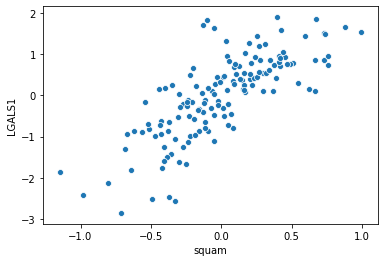

In [119]:
sns.scatterplot(x=score_df['squam'], y=expression_df.loc[SQUAM_GENES[0]])

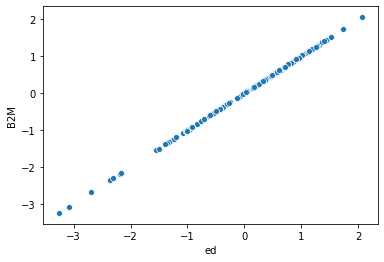

In [120]:
sns.scatterplot(x=score_df['ed'], y=expression_df.loc[ED_GENES[0]])

In [121]:
# score_df = pd.DataFrame(data=score_df.values / np.max(score_df.values, axis=0),
#                        columns=score_df.columns, index=score_df.index)
score_df = pd.DataFrame(data=score_df.values,
                       columns=score_df.columns, index=score_df.index)
score_df['dataset'] = 'moffit'
score_df

,squam,ed,dataset
GSM1844105,-1.148751,0.919678,moffit
GSM1844106,0.759994,-1.370429,moffit
GSM1844107,0.298560,0.729917,moffit
GSM1844108,-0.046253,-0.961713,moffit
GSM1844109,-0.714885,-3.088009,moffit
...,...,...,...
GSM1844245,-0.240870,0.613141,moffit
GSM1844246,-0.543581,-0.497853,moffit
GSM1844247,-0.644656,-0.917922,moffit
GSM1844248,0.391322,-2.311124,moffit


In [122]:
moffit_metadata = pd.read_csv('../data/bulk_rna_seq/moffit/metadata.tsv', sep='\t')
moffit_metadata = moffit_metadata.set_index('sample_id')
moffit_metadata.columns = ['source', 'cell line/tissue', 'death_event_1death_0censor', 'stroma', 'survival_time',
                           'tissue_type', 'tumor_subtype']

moffit_combined = pd.merge(score_df, moffit_metadata, left_index=True, right_index=True)
moffit_combined = moffit_combined[moffit_combined['survival_time'] > 0]
moffit_combined['status'] = [int(x) + 1 for x in moffit_combined['death_event_1death_0censor']]
moffit_combined.index.name = 'sample_id'

moffit_combined.columns = [x.replace(' ', '_') for x in moffit_combined.columns]

moffit_combined

,squam,ed,dataset,source,cell_line/tissue,death_event_1death_0censor,stroma,survival_time,tissue_type,tumor_subtype,status
sample_id,,,,,,,,,,,
GSM1844112,0.878219,-0.613007,moffit,Pancreas_Primary,Pancreas,1.0,1,7.0,Primary,2,2
GSM1844113,0.196517,0.446087,moffit,Pancreas_Primary,Pancreas,1.0,3,11.0,Primary,2,2
GSM1844114,-0.131142,0.828852,moffit,Pancreas_Primary,Pancreas,0.0,2,47.0,Primary,1,1
GSM1844115,0.274337,0.770464,moffit,Pancreas_Primary,Pancreas,1.0,3,10.0,Primary,1,2
GSM1844116,-0.672783,1.740354,moffit,Pancreas_Primary,Pancreas,1.0,3,1.0,Primary,1,2
...,...,...,...,...,...,...,...,...,...,...,...
GSM1844238,0.056010,-1.391513,moffit,Pancreas_Primary,Pancreas,1.0,3,17.0,Primary,1,2
GSM1844239,-0.165242,-0.423246,moffit,Pancreas_Primary,Pancreas,0.0,3,1.0,Primary,1,1
GSM1844240,-0.194863,-0.421624,moffit,Pancreas_Primary,Pancreas,1.0,2,20.0,Primary,1,2


## create clinical dfs

In [123]:
subtype_scores = ['squam', 'ed']

In [124]:
clinical_columns = ['age', 'sex', 'race', 'tumor_stage', 'morphology']

In [125]:
bailey_combined['age'] = bailey_combined['donor_age_at_diagnosis'].astype('Int64')
tcga_combined['age'] = [int(x / 365) for x in tcga_combined['age_at_diagnosis']]
moffit_combined['age'] = np.full((moffit_combined.shape[0],), np.nan)

ages = [x for df in [bailey_combined, moffit_combined, tcga_combined]
       for x in df['age']]
len(ages)

346

In [126]:
bailey_combined['gender'] = bailey_combined['donor_sex']
moffit_combined['gender'] = np.full((moffit_combined.shape[0],), 'unknown')

genders = [x for df in [bailey_combined, moffit_combined, tcga_combined]
       for x in df['gender']]
len(genders)

346

In [127]:
tcga_combined['race'][tcga_combined['race'] == 'not reported'] = 'unknown'

bailey_combined['race'] = np.full((bailey_combined.shape[0],), 'unknown')
moffit_combined['race'] = np.full((moffit_combined.shape[0],), 'unknown')

races = [x for df in [bailey_combined, moffit_combined, tcga_combined]
       for x in df['race']]
len(races)

/diskmnt/Projects/Users/estorrs/miniconda3/envs/sc_pdac/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


346

In [128]:
bailey_combined['tumor_stage'] = np.full((bailey_combined.shape[0],), 'unknown')
moffit_combined['tumor_stage'] = np.full((moffit_combined.shape[0],), 'unknown')


tumor_stages = [x for df in [bailey_combined, moffit_combined, tcga_combined]
       for x in df['tumor_stage']]
len(tumor_stages)

346

In [129]:
survival_times = [x for df in [bailey_combined, moffit_combined, tcga_combined]
       for x in df['survival_time']]
statuses = [x for df in [bailey_combined, moffit_combined, tcga_combined]
       for x in df['status']]

datasets = ['bailey'] * bailey_combined.shape[0]
datasets += ['moffit'] * moffit_combined.shape[0]
datasets += ['tcga'] * tcga_combined.shape[0]



len(survival_times), len(statuses)

(346, 346)

In [130]:
indices = [x for df in [bailey_combined, moffit_combined, tcga_combined]
       for x in df.index]

In [131]:
clinical_df = pd.DataFrame.from_dict({
    'age': ages,
    'gender': genders,
    'race': races,
    'tumor_stage': tumor_stages,
    'survival_time': survival_times,
    'status': statuses,
    'dataset': datasets
})
clinical_df.index = indices
clinical_df['age'] = clinical_df['age'].astype('Int64')
clinical_df['survival_time'] = clinical_df['survival_time'].astype('Int64')

clinical_df

,age,gender,race,tumor_stage,survival_time,status,dataset
SA518851,67,male,unknown,unknown,5,2,bailey
SA528766,61,female,unknown,unknown,8,2,bailey
SA528763,52,male,unknown,unknown,36,2,bailey
SA518854,55,male,unknown,unknown,5,1,bailey
SA518806,51,female,unknown,unknown,14,2,bailey
...,...,...,...,...,...,...,...
TCGA-XN-A8T3,67,male,white,stage ib,31,1,tcga
TCGA-XN-A8T5,53,female,white,stage ib,23,1,tcga
TCGA-YB-A89D,59,male,white,stage iib,11,1,tcga
TCGA-YY-A8LH,61,female,white,stage iib,66,1,tcga


In [132]:
score_df = pd.concat((bailey_combined[subtype_scores],
                              moffit_combined[subtype_scores],
                              tcga_combined[subtype_scores]), axis=0)
score_df

,squam,ed
sample_id,,
SA518851,0.947864,-0.158793
SA528766,-0.817678,-0.971109
SA528763,-0.458382,-0.743776
SA518854,-0.143763,-0.454127
SA518806,-0.080723,-0.722004
...,...,...
TCGA-XN-A8T3,0.471022,-0.770297
TCGA-XN-A8T5,-0.100705,0.198475
TCGA-YB-A89D,-0.151450,-0.131779


In [133]:
np.count_nonzero(score_df.index==clinical_df.index)

346

In [134]:
combined = pd.concat((score_df, clinical_df), axis=1)
combined

,squam,ed,age,gender,race,tumor_stage,survival_time,status,dataset
sample_id,,,,,,,,,
SA518851,0.947864,-0.158793,67,male,unknown,unknown,5,2,bailey
SA528766,-0.817678,-0.971109,61,female,unknown,unknown,8,2,bailey
SA528763,-0.458382,-0.743776,52,male,unknown,unknown,36,2,bailey
SA518854,-0.143763,-0.454127,55,male,unknown,unknown,5,1,bailey
SA518806,-0.080723,-0.722004,51,female,unknown,unknown,14,2,bailey
...,...,...,...,...,...,...,...,...,...
TCGA-XN-A8T3,0.471022,-0.770297,67,male,white,stage ib,31,1,tcga
TCGA-XN-A8T5,-0.100705,0.198475,53,female,white,stage ib,23,1,tcga
TCGA-YB-A89D,-0.151450,-0.131779,59,male,white,stage iib,11,1,tcga


In [135]:
clinical_dir = f'../results/survival/eus_deconvolved_MHC_1'
Path(clinical_dir).mkdir(parents=True, exist_ok=True)

In [136]:
combined.to_csv(os.path.join(clinical_dir, 'all.tsv'), sep='\t', header=True, index=True)

In [137]:
combined[combined['dataset']=='bailey'].to_csv(os.path.join(clinical_dir, 'bailey_clinical.tsv'),
                                                sep='\t', header=True, index=True)
combined[combined['dataset']=='moffit'].to_csv(os.path.join(clinical_dir, 'moffit_clinical.tsv'),
                                                sep='\t', header=True, index=True)
combined[combined['dataset']=='tcga'].to_csv(os.path.join(clinical_dir, 'tcga_clinical.tsv'),
                                                sep='\t', header=True, index=True)

In [138]:
combined

,squam,ed,age,gender,race,tumor_stage,survival_time,status,dataset
sample_id,,,,,,,,,
SA518851,0.947864,-0.158793,67,male,unknown,unknown,5,2,bailey
SA528766,-0.817678,-0.971109,61,female,unknown,unknown,8,2,bailey
SA528763,-0.458382,-0.743776,52,male,unknown,unknown,36,2,bailey
SA518854,-0.143763,-0.454127,55,male,unknown,unknown,5,1,bailey
SA518806,-0.080723,-0.722004,51,female,unknown,unknown,14,2,bailey
...,...,...,...,...,...,...,...,...,...
TCGA-XN-A8T3,0.471022,-0.770297,67,male,white,stage ib,31,1,tcga
TCGA-XN-A8T5,-0.100705,0.198475,53,female,white,stage ib,23,1,tcga
TCGA-YB-A89D,-0.151450,-0.131779,59,male,white,stage iib,11,1,tcga


In [139]:
# !pip install lifelines

In [140]:
import altair as alt

In [141]:
t = combined.copy()
t = t[t['dataset']=='bailey']
t = t[t['survival_time']<50]
chart = alt.Chart(t).mark_point().encode(
    x='survival_time',
    y='ed',
    color='squam'
)
chart

alt.Chart(...)

In [142]:
t = combined.copy()
t['sample_id'] = t.index.to_list()
# exclude the weird bailey sample
t = t.loc[[s for s in t.index if s != 'SA407858']]
# t = t[t['survival_time']<51]


chart = alt.Chart(t).mark_circle().encode(
    x='survival_time',
    y='ed',
    color='dataset',
    tooltip=['sample_id', 'tumor_stage'],
)
c1 = chart + chart.transform_regression('survival_time', 'ed', groupby=['dataset']).mark_line()
c1
# chart = alt.Chart(combined[combined['dataset']=='bailey']).mark_circle().encode(
#     x='survival_time',
#     y='ed',
#     color='blue'
# )
# c1 = chart + chart.transform_regression('survival_time', 'ed').mark_line()

alt.LayerChart(...)

In [143]:
t = combined.copy()
t['sample_id'] = t.index.to_list()
# exclude the weird bailey sample
t = t.loc[[s for s in t.index if s != 'SA407858']]

t = t[t['survival_time']<50]
t = t[t['squam']<=.8]

chart = alt.Chart(t).mark_circle().encode(
    x='survival_time',
    y='ed',
    color='dataset',
    tooltip=['sample_id'],
)
c1 = chart + chart.transform_regression('survival_time', 'ed', groupby=['dataset']).mark_line()
c1
# chart = alt.Chart(combined[combined['dataset']=='bailey']).mark_circle().encode(
#     x='survival_time',
#     y='ed',
#     color='blue'
# )
# c1 = chart + chart.transform_regression('survival_time', 'ed').mark_line()

alt.LayerChart(...)

In [144]:
t = combined.copy()
t['sample_id'] = t.index.to_list()
# exclude the weird bailey sample
t = t.loc[[s for s in t.index if s != 'SA407858']]
# t = t[t['survival_time']>=6]
# t = t[t['survival_time']<50]

chart = alt.Chart(t).mark_circle().encode(
    x='survival_time',
    y='squam',
    color='dataset',
    tooltip=['sample_id'],
)
c1 = chart + chart.transform_regression('survival_time', 'squam', groupby=['dataset']).mark_line()
c1
# chart = alt.Chart(combined[combined['dataset']=='bailey']).mark_circle().encode(
#     x='survival_time',
#     y='ed',
#     color='blue'
# )
# c1 = chart + chart.transform_regression('survival_time', 'ed').mark_line()

alt.LayerChart(...)

In [ ]:
def get_pvals(df, cuts, field):
    pvals = []
    for cut in cuts:
        l1, l2 = df[df[field]<cut], df[df[field]>=cut]
        results = logrank_test(l1['survival_time'], l2['survival_time'],
                               event_observed_A=l1['status'], event_observed_B=l2['status'])
        pvals.append(results.p_value)
    return pd.DataFrame.from_dict({
        'cutpoint': cuts,
        'p-value': pvals
    })

def marked_survival_chart(survival, field, steps=100):
    r = max(survival[field]) - min(survival[field])
    df = get_pvals(survival,
#                    np.asarray(range(-200, 200, steps)) / steps, field)
        np.asarray(range(-200, 200, 2)) / steps, field)
    df[field] = df['cutpoint'].to_list()
    
    c1 = alt.Chart(df).mark_line().encode(
        y='ed',
        x='p-value',
        order='ed'
    #     tooltip='p-value'
    )
    marks = alt.Chart(df).mark_circle().encode(
        y='ed',
        x='p-value',
        tooltip='p-value'
    )
    return c1 + marks

t = combined[combined['survival_time']<=14].copy()
t = t[t['dataset']=='bailey']

c1 = marked_survival_chart(t, 'ed')

c2 = alt.Chart(t).mark_circle().encode(
    y='ed',
    x='survival_time',
    color='dataset',
#     tooltip=['sample_id', 'tumor_stage'],
)
c2 = c2 + c2.transform_regression('survival_time', 'ed', groupby=['dataset']).mark_line()


(c2 | c1).resolve_scale(y='shared')

In [ ]:
def get_pvals(df, cuts, field):
    pvals = []
    for cut in cuts:
        l1, l2 = df[df[field]<cut], df[df[field]>=cut]
        results = logrank_test(l1['survival_time'], l2['survival_time'],
                               event_observed_A=l1['status'], event_observed_B=l2['status'])
        pvals.append(results.p_value)
    return pd.DataFrame.from_dict({
        'cutpoint': cuts,
        'p-value': pvals
    })

def marked_survival_chart(survival, field, steps=100):
    r = max(survival[field]) - min(survival[field])
    df = get_pvals(survival,
#                    np.asarray(range(-200, 200, steps)) / steps, field)
        np.asarray(range(-200, 200, 2)) / steps, field)
    df[field] = df['cutpoint'].to_list()
    
    c1 = alt.Chart(df).mark_line().encode(
        y='squam',
        x='p-value',
        order='squam'
    #     tooltip='p-value'
    )
    marks = alt.Chart(df).mark_circle().encode(
        y='squam',
        x='p-value',
        tooltip='p-value'
    )
    return c1 + marks

t = combined[combined['survival_time']<60].copy()
t = t[t['dataset']=='bailey']

c1 = marked_survival_chart(t, 'squam')

c2 = alt.Chart(t).mark_circle().encode(
    y='squam',
    x='survival_time',
    color='dataset',
#     tooltip=['sample_id', 'tumor_stage'],
)
c2 = c2 + c2.transform_regression('survival_time', 'squam', groupby=['dataset']).mark_line()


(c2 | c1).resolve_scale(y='shared')

In [ ]:
def get_pvals(df, cuts, field):
    pvals = []
    for cut in cuts:
        l1, l2 = df[df[field]<cut], df[df[field]>=cut]
        results = logrank_test(l1['survival_time'], l2['survival_time'],
                               event_observed_A=l1['status'], event_observed_B=l2['status'])
        pvals.append(results.p_value)
    return pd.DataFrame.from_dict({
        'cutpoint': cuts,
        'p-value': pvals
    })

def marked_survival_chart(survival, field, steps=100):
    r = max(survival[field]) - min(survival[field])
    df = get_pvals(survival,
#                    np.asarray(range(-200, 200, steps)) / steps, field)
        np.asarray(range(-200, 200, 2)) / steps, field)
    df[field] = df['cutpoint'].to_list()
    
    c1 = alt.Chart(df).mark_line().encode(
        y='ed',
        x='p-value',
        order='ed'
    #     tooltip='p-value'
    )
    marks = alt.Chart(df).mark_circle().encode(
        y='ed',
        x='p-value',
        tooltip='p-value'
    )
    return c1 + marks

t = combined[combined['survival_time']<=51].copy()
# t = combined.copy()
t = t[t['dataset']=='tcga']

c1 = marked_survival_chart(t, 'ed')

c2 = alt.Chart(t).mark_circle().encode(
    y='ed',
    x='survival_time',
    color='dataset',
#     tooltip=['sample_id', 'tumor_stage'],
)
c2 = c2 + c2.transform_regression('survival_time', 'ed', groupby=['dataset']).mark_line()


(c2 | c1).resolve_scale(y='shared')

In [ ]:
def get_pvals(df, cuts, field):
    pvals = []
    for cut in cuts:
        l1, l2 = df[df[field]<cut], df[df[field]>=cut]
        results = logrank_test(l1['survival_time'], l2['survival_time'],
                               event_observed_A=l1['status'], event_observed_B=l2['status'])
        pvals.append(results.p_value)
    return pd.DataFrame.from_dict({
        'cutpoint': cuts,
        'p-value': pvals
    })

def marked_survival_chart(survival, field, steps=100):
    r = max(survival[field]) - min(survival[field])
    df = get_pvals(survival,
#                    np.asarray(range(-200, 200, steps)) / steps, field)
        np.asarray(range(-200, 200, 2)) / steps, field)
    df[field] = df['cutpoint'].to_list()
    
    c1 = alt.Chart(df).mark_line().encode(
        y='ed',
        x='p-value',
        order='ed'
    #     tooltip='p-value'
    )
    marks = alt.Chart(df).mark_circle().encode(
        y='ed',
        x='p-value',
        tooltip='p-value'
    )
    return c1 + marks

t = combined[combined['survival_time']<60].copy()
t = t[t['dataset']=='moffit']

c1 = marked_survival_chart(t, 'ed')

c2 = alt.Chart(t).mark_circle().encode(
    y='ed',
    x='survival_time',
    color='dataset',
#     tooltip=['sample_id', 'tumor_stage'],
)
c2 = c2 + c2.transform_regression('survival_time', 'ed', groupby=['dataset']).mark_line()


(c2 | c1).resolve_scale(y='shared')

In [ ]:
t = combined.copy()
t['sample_id'] = t.index.to_list()
t['ed_bin'] = ['LD' if x < 1. else 'ED' for x in t['ed']]
t['sq_bin'] = ['SQ' if x >= .3 else 'CL' for x in t['squam']]
def get_bin(s, e):
#     if s > .25: return 'SQ'
    if e > 0.5: return 'ED'
    return 'LD'
t['overall_bin'] = [get_bin(s, e) for s, e in zip(t['squam'], t['ed'])]

In [ ]:
kmf = KaplanMeierFitter()
ft = t[t['dataset']=='tcga']
T = ft['survival_time']
E = ft['status']
groups = ft['overall_bin']

kmf.fit(T[groups=='LD'], E[groups=='LD'], label='LD')
ax = kmf.plot(show_censors=True, ci_show=False, )

kmf.fit(T[groups=='ED'], E[groups=='ED'], label='ED')
ax = kmf.plot(ax=ax, show_censors=True, ci_show=False, )

# kmf.fit(T[groups=='SQ'], E[groups=='SQ'], label='SQ')
# ax = kmf.plot(ax=ax, show_censors=True, ci_show=False, )

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
ft = t[t['dataset']=='moffit']
T = ft['survival_time']
E = ft['status']
groups = ft['sq_bin']

kmf.fit(T[groups=='CL'], E[groups=='CL'], label='CL')
ax = kmf.plot(show_censors=True, ci_show=False, )

kmf.fit(T[groups=='SQ'], E[groups=='SQ'], label='SQ')
ax = kmf.plot(ax=ax, show_censors=True, ci_show=False, )

In [ ]:
from lifelines.statistics import logrank_test
results = logrank_test(T[groups=='ED'], T[groups=='LD'], event_observed_A=E[groups=='ED'], event_observed_B=E[groups=='LD'])
results.print_summary()

In [ ]:
results.p_value

In [ ]:
results = logrank_test(T[groups=='SQ'], T[groups=='LD'], event_observed_A=E[groups=='SQ'], event_observed_B=E[groups=='LD'])
results.print_summary()

In [ ]:
SA407858

In [ ]:
chart = alt.Chart(combined[combined['dataset']=='bailey']).mark_circle().encode(
    x='survival_time',
    y='ed',
    color='squam'
)
chart + chart.transform_regression('survival_time', 'ed').mark_line()

In [ ]:
p = combined[((combined['dataset']=='bailey') & (combined['status']==2))].copy()
sns.scatterplot(x='survival_time', y='squam', data=p)
plt.show()
sns.scatterplot(x='survival_time', y='ed', data=p, hue='squam')
plt.show()

In [ ]:
sns.scatterplot(x='ed', y='squam', data=p)
plt.show()

In [ ]:
p = combined[((combined['dataset']=='bailey') & (combined['status']==2))].copy()
sns.scatterplot(x='survival_time', y='squam', data=p)
plt.show()
sns.scatterplot(x='survival_time', y='ed', data=p)
plt.show()

In [ ]:
p = combined[((combined['dataset']=='moffit') & (combined['status']==2))].copy()
sns.scatterplot(x='survival_time', y='squam', data=p)
plt.show()
sns.scatterplot(x='survival_time', y='ed', data=p)
plt.show()

## moffit overlap

In [ ]:
moffit_combined['moffit_subtype'] = ['squamous-like' if s == 2 else 'non-squamous'
                                    for s in moffit_combined['tumor_subtype']]
moffit_combined

In [ ]:
sns.boxplot(x='moffit_subtype', y='squam', data=moffit_combined)
sns.swarmplot(x='moffit_subtype', y='squam', data=moffit_combined, color='black')
plt.savefig(os.path.join(figdir, f'moffit_overlap_{THRESH}.pdf'))

In [ ]:
p = moffit_combined[((moffit_combined['status']==2))]
sns.boxplot(x='moffit_subtype', y='survival_time', data=p)
sns.swarmplot(x='moffit_subtype', y='survival_time', data=p,
              color='black')

## bailey overlap

In [ ]:
bailey_subtypes = pd.read_excel('../data/bulk_rna_seq/bailey/41586_2016_BFnature16965_MOESM271_ESM.xlsx')
bailey_subtypes

In [ ]:
bailey_combined

In [ ]:
p = pd.merge(bailey_combined, bailey_subtypes, left_on='submitted_donor_id_x', right_on='icgc_id')

In [ ]:
subtype_map = {
    1: 'ADEX',
    2: 'Immunogenic',
    3: 'Squamous',
    4: 'Pancreatic Progenitor'
}

In [ ]:
p['bailey_subtype'] = [subtype_map[s]
        for s in p['membership.ordered']]
p

In [ ]:
sns.boxplot(x='bailey_subtype', y='squam', data=p)
sns.swarmplot(x='bailey_subtype', y='squam', data=p, color='black')
plt.savefig(os.path.join(figdir, f'bailey_overlap_{THRESH}.pdf'))

In [ ]:
# p = p[((p['status']==2))]
sns.boxplot(x='bailey_subtype', y='survival_time', data=p[((p['status']==2))])
sns.swarmplot(x='bailey_subtype', y='survival_time', data=p[((p['status']==2))],
              color='black')